In [20]:
import auxfunctions as aux
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import cv2
import imageio.v3 as iio
import sklearn as sk
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.cluster import SpectralClustering
from matplotlib import colors
import sklearn.cluster
from scipy.spatial import distance



In [61]:
import cv2
import sklearn.cluster
import numpy as np
import matplotlib.pyplot as plt

EPS = 0.1
MIN_SAMPLES = 20
P_PARAM = 1.5
SMALLER_PARAM = 5
MIN_WEIGHT = 0.7
FIGSIZE = (8, 8)
IMG_OUTPUT_PATH = "new_img.jpg"


@aux.measure_time
def quantize(img_path, txt=""):
    img = cv2.imread(img_path)
    aux.plot_3d_hist(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), "before_quantization")

    r, g, b = img[:, :, 0].flatten(), img[:, :, 1].flatten(), img[:, :, 2].flatten()
    transformed_points = aux.trasform_points(r, g, b)
    
    weights = normalize_weights(transformed_points[:, 2])
    X = get_relevant_X_points(transformed_points, weights)
    plot_X_points(X, img_path, txt)

    kmeans, labels = perform_clustering(X)
    unique_labels, cluster_centers = compute_cluster_centers(X, labels)

    plot_cluster_centers_lines(cluster_centers)

    print_cluster_info(unique_labels, cluster_centers)
    plot_clusters(X, kmeans, cluster_centers, img_path, txt)

    new_img = transform_img_to_lines(img, r, g, b, cluster_centers)
    new_img = (new_img / np.max(new_img)) * 255
    new_img_colored = cv2.cvtColor(new_img.astype(np.uint8), cv2.COLOR_BGR2RGB)

    aux.plot_3d_hist(new_img_colored, "after_quantization")
    aux.plot_2_images(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), new_img_colored)

    # write to a file
    cv2.imwrite(IMG_OUTPUT_PATH, new_img)


def normalize_weights(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
    # return weights


def get_relevant_X_points(transformed_points, weights):
    return transformed_points[:, :2][::SMALLER_PARAM][weights[::SMALLER_PARAM] > MIN_WEIGHT]


def plot_X_points(X, img_path, txt):
    fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
    ax.scatter(X[:, 0], X[:, 1], c="b")
    ax.set_title("X points")
    plt.savefig(f"{img_path}_DBSCAN_X_{txt}.png")
    plt.show()


def perform_clustering(X):
    spectral = SpectralClustering(n_clusters=7, affinity='rbf', assign_labels="kmeans", random_state=0)
    labels = spectral.fit_predict(X)
    return spectral, labels


def compute_cluster_centers(X, labels):
    unique_labels = set(labels) - {-1}
    cluster_centers = np.array([np.mean(X[labels == label], axis=0) for label in unique_labels])
    return unique_labels, cluster_centers


def print_cluster_info(unique_labels, cluster_centers):
    for label, center in zip(unique_labels, cluster_centers):
        print("Cluster with label {} has center {}".format(label, center))
    print("Number of clusters (excluding noise points):", len(cluster_centers))


def plot_clusters(X, kmeans, cluster_centers, img_path, txt):
    fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
    ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap="viridis")
    ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker="x", s=100, c="r")
    ax.set_title("DBSCAN clusters")
    plt.savefig(f"{img_path}_DBSCAN_DBSCAN_{txt}.png")
    plt.show()


def transform_img_to_lines(img, r, g, b, cluster_centers):
    lines = aux.polar_to_line(cluster_centers[:, 0], cluster_centers[:, 1], 300)
    new_points = aux.transform_points_to_lines((r, g, b), lines)
    new_img = new_points.reshape(img.shape)
    return new_img

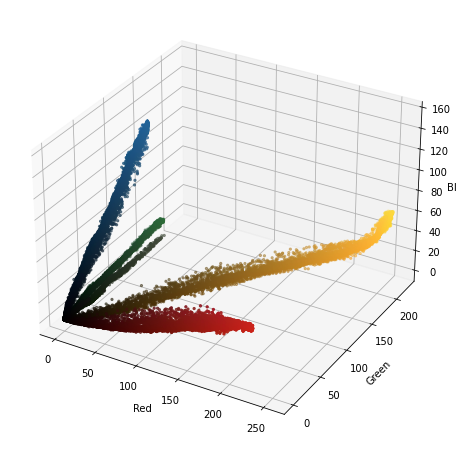

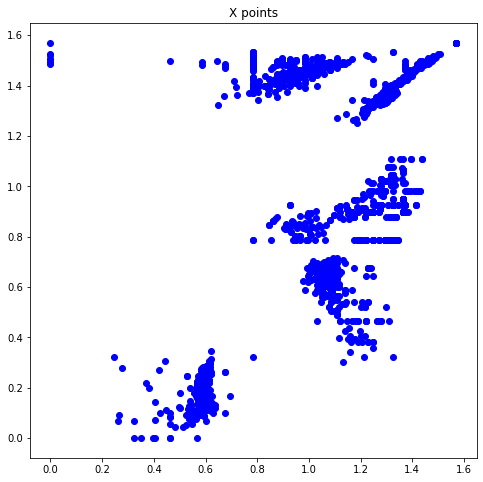

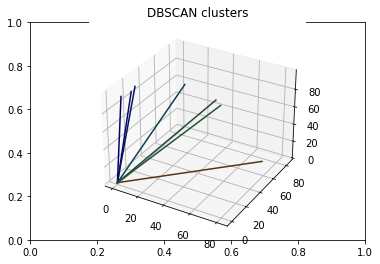

Cluster with label 0 has center [0.92 1.45]
Cluster with label 1 has center [0.    1.515]
Cluster with label 2 has center [0.5815 0.2064]
Cluster with label 3 has center [1.3125 1.382 ]
Cluster with label 4 has center [1.058  0.6763]
Cluster with label 5 has center [1.272 0.895]
Cluster with label 6 has center [1.1875 0.4526]
Number of clusters (excluding noise points): 7


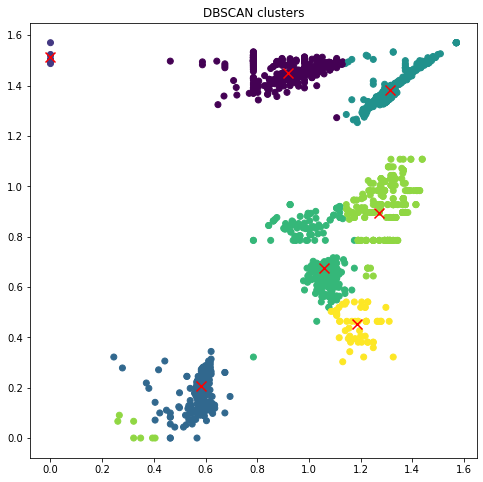

Execution time:  1.0  minutes and  55.487  seconds


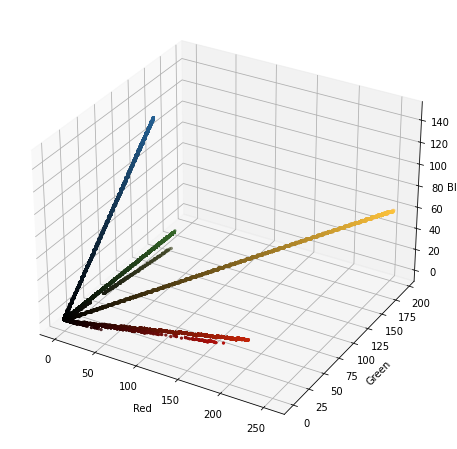

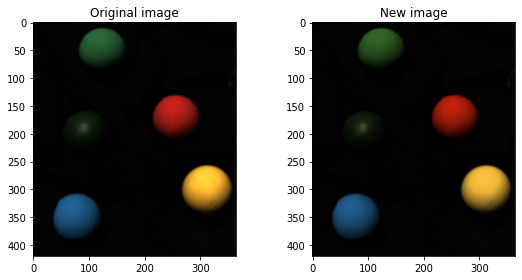

Execution time:  1.0  minutes and  10.273  seconds


In [62]:
quantize("media for readme/colored balls.png", "red_ball")

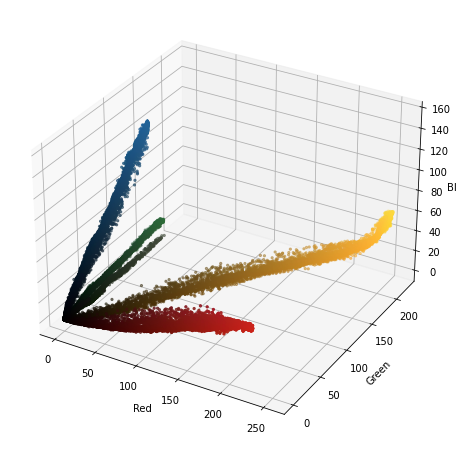

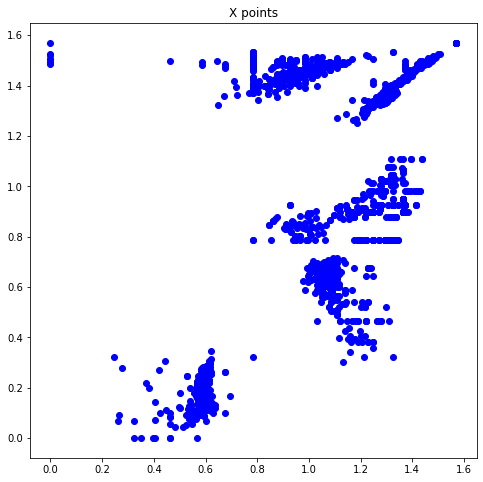

transformed_points.shape (153300, 3)
(153300,)
Cluster with label 0 has center [0.92 1.45]
Cluster with label 1 has center [0.    1.515]
Cluster with label 2 has center [0.5815 0.2064]
Cluster with label 3 has center [1.3125 1.382 ]
Cluster with label 4 has center [1.058  0.6763]
Cluster with label 5 has center [1.272 0.895]
Cluster with label 6 has center [1.1875 0.4526]
Number of clusters (excluding noise points): 7


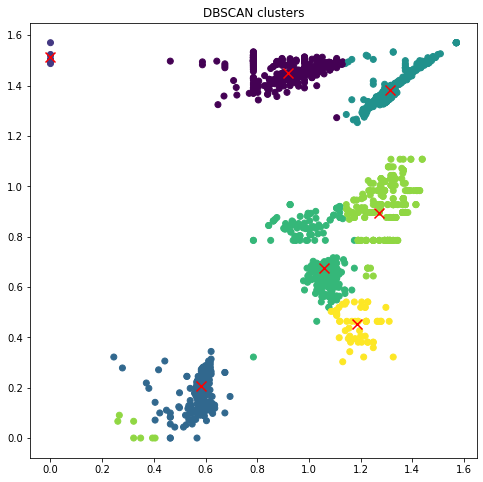

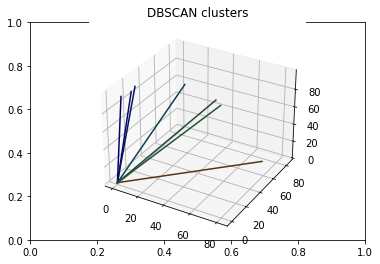

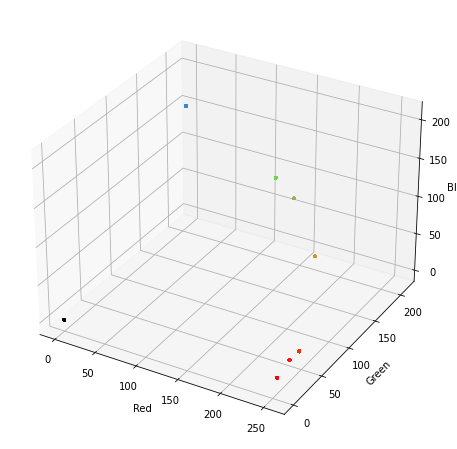

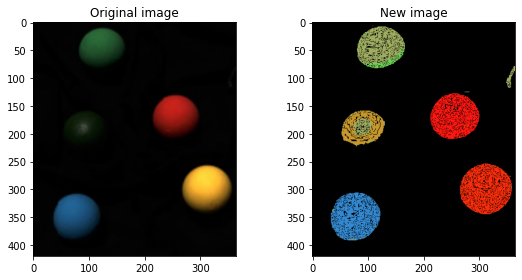

Execution time:  0.0  minutes and  16.117  seconds


In [57]:
from sklearn.neighbors import KNeighborsClassifier


# a function that quantizes an image, to one set of colors (not hues)
@aux.measure_time
def quantize_colors(img_path, txt=""):
    img = cv2.imread(img_path)
    aux.plot_3d_hist(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), "before_quantization")

    r, g, b = img[:, :, 0].flatten(), img[:, :, 1].flatten(), img[:, :, 2].flatten()
    transformed_points = aux.trasform_points(r, g, b)

    weights = normalize_weights(transformed_points[:, 2])
    X = get_relevant_X_points(transformed_points, weights)
    plot_X_points(X, img_path, txt)

    kmeans, labels = perform_clustering(X)
    unique_labels, cluster_centers = compute_cluster_centers(X, labels)

    print("transformed_points.shape", transformed_points.shape)
    all_labels = nearest_neighbor_classifier(X, labels, transformed_points[:, :2], transformed_points[:, 2])
    print(all_labels.shape)

    print_cluster_info(unique_labels, cluster_centers)
    plot_clusters(X, kmeans, cluster_centers, img_path, txt)
    plot_cluster_centers_lines(cluster_centers)

    colors = transform_cluster_centers_to_colors(cluster_centers)
    new_points = transform_img_to_colors(all_labels, colors)
    new_img = new_points.reshape(img.shape)
    new_img = (new_img / np.max(new_img)) * 255
    new_img_colored = cv2.cvtColor(new_img.astype(np.uint8), cv2.COLOR_BGR2RGB)

    aux.plot_3d_hist(new_img_colored, "after_quantization")
    aux.plot_2_images(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), new_img_colored)

    # write to a file
    cv2.imwrite(IMG_OUTPUT_PATH, new_img)

def plot_cluster_centers_lines(cluster_centers):
    fig = plt.subplots()
    ax = plt.axes(projection='3d')
    norm = plt.Normalize(0, 255)
    for center in cluster_centers:
        line = np.array([(0,0,0), aux.polar_to_cartesian(center[0], center[1], 100)])
        ax.plot3D(line[:, 0], line[:, 1], line[:, 2], color=np.array(norm(line[1, :])).T)
    ax.set_title("DBSCAN clusters")
    plt.show()

def nearest_neighbor_classifier(sampled_data, labels, unsampled_data, r):
    # First, train the classifier
    clf = KNeighborsClassifier(n_neighbors=10)
    clf.fit(sampled_data, labels)

    # Then, predict the labels of the unsampled data
    predicted_labels = clf.predict(unsampled_data)
    predicted_labels[r < 7] = len(np.unique(labels))
    return predicted_labels

# transform the cluster centers in the hough domain to a strong representation in the image domain
def transform_cluster_centers_to_colors(cluster_centers):
    colors = []
    for center in cluster_centers:
        colors.append(aux.polar_to_cartesian(center[0], center[1], 100))
    colors.append([0, 0, 0])
    return np.array(colors) # add black color for the noise points

# # function that takes each point to each cluster center
# def transform_img_to_colors(labels, colors):
#     pixels = []
#     for i in range(len(labels)):
#         pixels.append(colors[labels[i]])
#     return np.array(pixels)
def transform_img_to_colors(labels, colors):
    return colors[labels]

quantize_colors("media for readme/colored balls.png", "red_ball_colors")